# Lending club regression

## Environment Preparation

* Load the SDK code from the local package directory
* Load the API key and secret in the .env file

In [1]:
# Quick hack to load local SDK code
import os

os.chdir(os.path.join(os.getcwd(), ".."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

True

## ValidMind SDK Introduction

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = None

In [3]:
# Initialize ValidMind SDK
import validmind as vm

# For test environment use api_host="https://api.test.vm.validmind.ai/api/v1/tracking"
# vm.init(project="cl2r3k1ri000009jweny7ba1g")

In [4]:
df = pd.read_csv("./notebooks/datasets/_temp/loan_data_2007_2014_preprocessed.csv")

# targets = vm.DatasetTargets(
#     target_column="loan_status",
#     class_labels={
#         "Fully Paid": "Fully Paid",
#         "Charged Off": "Charged Off",
#     }
# )

# vm_dataset = vm.log_dataset(df, "training", analyze=True, targets=targets)

Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
loan_data_defaults = df[df['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [6]:
loan_data_defaults.shape

(43236, 209)

In [7]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace=True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# We calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

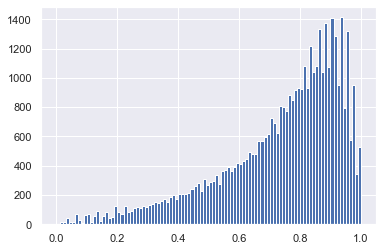

In [10]:
plt.hist(loan_data_defaults['CCF'], bins = 100)

In [11]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [12]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

In [13]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']
# List of the dummy variable reference categories. 

In [14]:
ead_inputs_train = ead_inputs_train[features_all]

In [15]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [16]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import scipy.stats as stat

In [17]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [18]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.


LinearRegression()

In [19]:
feature_name = ead_inputs_train.columns.values

In [20]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_ead.p
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


In [21]:
ead_inputs_test = ead_inputs_test[features_all]
# Here we keep only the variables we need for the model.

In [22]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [23]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [24]:
ead_targets_test_temp = ead_targets_test

In [25]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [26]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='CCF', ylabel='Density'>

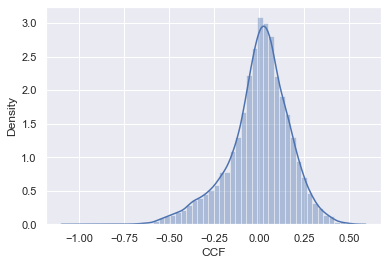

In [27]:
sns.distplot(ead_targets_test - y_hat_test_ead)
# We plot the distribution of the residuals.

In [28]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [29]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [30]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


In [31]:
mean_squared_error(ead_targets_test, y_hat_test_ead)

0.0291749760949319

In [32]:
r2_score(ead_targets_test, y_hat_test_ead)

0.2822776667644732

In [33]:
xgb_model = xgb.XGBRegressor()
xgb_model.set_params(
    booster='gblinear',
    eval_metric=mean_squared_error,
)

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x169861310>,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [42]:
xgb_model.fit(ead_inputs_train, ead_targets_train, eval_set=[(ead_inputs_train, ead_targets_train), (ead_inputs_test, ead_targets_test)],)

[0]	validation_0-rmse:0.18787	validation_0-mean_squared_error:0.03529	validation_1-rmse:0.18834	validation_1-mean_squared_error:0.03547
[1]	validation_0-rmse:0.18491	validation_0-mean_squared_error:0.03419	validation_1-rmse:0.18507	validation_1-mean_squared_error:0.03425
[2]	validation_0-rmse:0.18372	validation_0-mean_squared_error:0.03375	validation_1-rmse:0.18379	validation_1-mean_squared_error:0.03378
[3]	validation_0-rmse:0.18299	validation_0-mean_squared_error:0.03348	validation_1-rmse:0.18312	validation_1-mean_squared_error:0.03353
[4]	validation_0-rmse:0.18238	validation_0-mean_squared_error:0.03326	validation_1-rmse:0.18246	validation_1-mean_squared_error:0.03329
[5]	validation_0-rmse:0.18177	validation_0-mean_squared_error:0.03304	validation_1-rmse:0.18202	validation_1-mean_squared_error:0.03313
[6]	validation_0-rmse:0.18120	validation_0-mean_squared_error:0.03283	validation_1-rmse:0.18152	validation_1-mean_squared_error:0.03295
[7]	validation_0-rmse:0.18075	validation_0-mean_

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x169861310>,
             gamma=None, gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0, ...)

In [44]:
y_hat_test_ead_xgb = xgb_model.predict(ead_inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [36]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead_xgb)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,CCF,0
CCF,1.00000,0.52144
0,0.52144,1.00000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='CCF', ylabel='Density'>

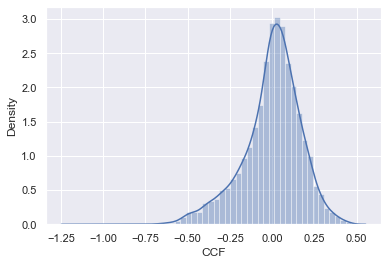

In [37]:
sns.distplot(ead_targets_test - y_hat_test_ead_xgb)
# We plot the distribution of the residuals.

In [38]:
pd.DataFrame(y_hat_test_ead_xgb).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.735745
std,0.101577
min,0.408254
25%,0.664853
50%,0.728506
75%,0.811329
max,1.310113


In [39]:
mean_squared_error(ead_targets_test, y_hat_test_ead_xgb)

0.029612655435575855

In [40]:
r2_score(ead_targets_test, y_hat_test_ead_xgb)

0.2715104861315287